# Ce modèle computer vision aide les vétérinaires à détecter la sévérité des pathologies cardiaques sur des radiographies thoraciques de chiens

In [73]:
import os
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import seaborn as sns

In [74]:
# Dossier contenant les images PNG
image_folder = "./VHS_dataset"

# Prétraitement (conforme à ResNet)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Charger les images
images = []
filenames = []

for filename in os.listdir(image_folder):
    if filename.endswith('.png'):
        path = os.path.join(image_folder, filename)
        image = Image.open(path).convert("RGB")
        image = transform(image)
        images.append(image)
        filenames.append(filename)

images = torch.stack(images)
print(f"{len(images)} images chargées.")


142 images chargées.


In [75]:
# Charger ResNet18 sans la dernière couche (feature extractor)
resnet = models.resnet18(pretrained=True)
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])  # remove FC layer
resnet.eval()

# Désactiver les gradients
with torch.no_grad():
    features = resnet(images).squeeze(-1).squeeze(-1)  # output: [N, 512]

features_np = features.numpy()
print("Shape des features :", features_np.shape)

c:\Users\Dorra Sioud\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Dorra Sioud\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Shape des features : (142, 512)


In [76]:
pca = PCA(n_components=50)
features_pca = pca.fit_transform(features_np)
print("Shape après PCA :", features_pca.shape)

Shape après PCA : (142, 50)


In [77]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
features_tsne = tsne.fit_transform(features_pca)
print("t-SNE terminé.")

t-SNE terminé.


In [78]:
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(features_tsne)

cluster_names = {
    0: "Sévère",      # ou "VHS élevé"
    1: "Modéré",      # ou "VHS intermédiaire"
    2: "Léger"        # ou "Proche de la normale"
}
# Associer noms de fichiers et clusters
results = list(zip(filenames, clusters))
for fname, cl in results[:10]:
    print(f"{fname} → cluster {cl}")

1.2.410.200028.100.3.20190920.1208500638.12380.1.5.png → cluster 2
1.2.410.200028.100.3.20190924.1430080534.21770.1.1.png → cluster 2
1.2.410.200028.100.3.20190925.1056080334.32610.1.2.png → cluster 1
1.2.410.200028.100.3.20190925.1427530769.8563.2.1.png → cluster 0
1.2.410.200028.100.3.20190926.1008510164.10580.1.2.png → cluster 2
1.2.410.200028.100.3.20190927.1023440667.730.1.1.png → cluster 1
1.2.410.200028.100.3.20190927.1032580692.2539.1.1.png → cluster 0
1.2.410.200028.100.3.20191003.1208190245.10162.1.1.png → cluster 0
1.2.410.200028.100.3.20191003.1216560845.11850.1.1LOL.png → cluster 0
1.2.410.200028.100.3.20191003.841320075.2414.1.1LOL.png → cluster 2


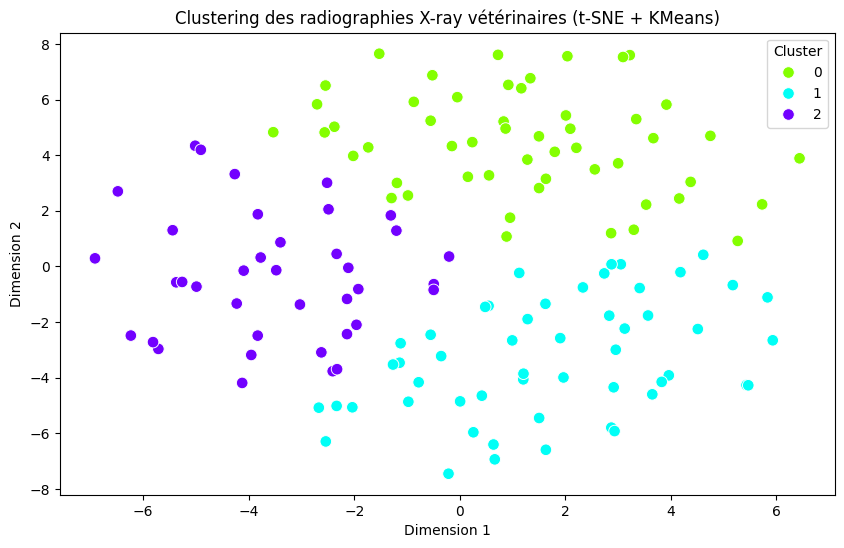

In [79]:
plt.figure(figsize=(10, 6))
palette = sns.color_palette("hsv", n_colors=3)
sns.scatterplot(x=features_tsne[:, 0], y=features_tsne[:, 1], hue=clusters, palette=palette, s=70)
plt.title("Clustering des radiographies X-ray vétérinaires (t-SNE + KMeans)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend(title="Cluster")
plt.show()

In [80]:
import shutil

output_base = "./clusters_output"
os.makedirs(output_base, exist_ok=True)

# Créer les dossiers pour chaque cluster
for i in range(3):
    os.makedirs(os.path.join(output_base, f"cluster_{i}"), exist_ok=True)

# Copier les fichiers
for fname, cl in zip(filenames, clusters):
    src_path = os.path.join(image_folder, fname)
    dest_path = os.path.join(output_base, f"cluster_{cl}", fname)
    shutil.copy(src_path, dest_path)

print("Images copiées dans leurs dossiers respectifs !")


Images copiées dans leurs dossiers respectifs !


In [81]:
import math

def show_images_per_cluster(clusters, filenames, image_folder, n=6):
    unique_clusters = sorted(set(clusters))
    
    for cluster_id in unique_clusters:
        print(f"\n🧠 Cluster {cluster_id}")
        idxs = [i for i, c in enumerate(clusters) if c == cluster_id][:n]
        total = len(idxs)

        cols = min(3, total)
        rows = math.ceil(total / cols)
        fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
        axes = axes.flatten() if total > 1 else [axes]

        for ax, idx in zip(axes, idxs):
            try:
                image_path = os.path.join(image_folder, filenames[idx])
                image = Image.open(image_path)
                ax.imshow(image, cmap='gray')
                ax.set_title(f"{filenames[idx][:20]}...", fontsize=8)
                ax.axis('off')
            except Exception as e:
                print(f"Erreur avec {filenames[idx]} : {e}")

        # Cacher les cases vides
        for j in range(len(idxs), len(axes)):
            axes[j].axis('off')

        plt.tight_layout()
        plt.show()


🧠 Cluster 0


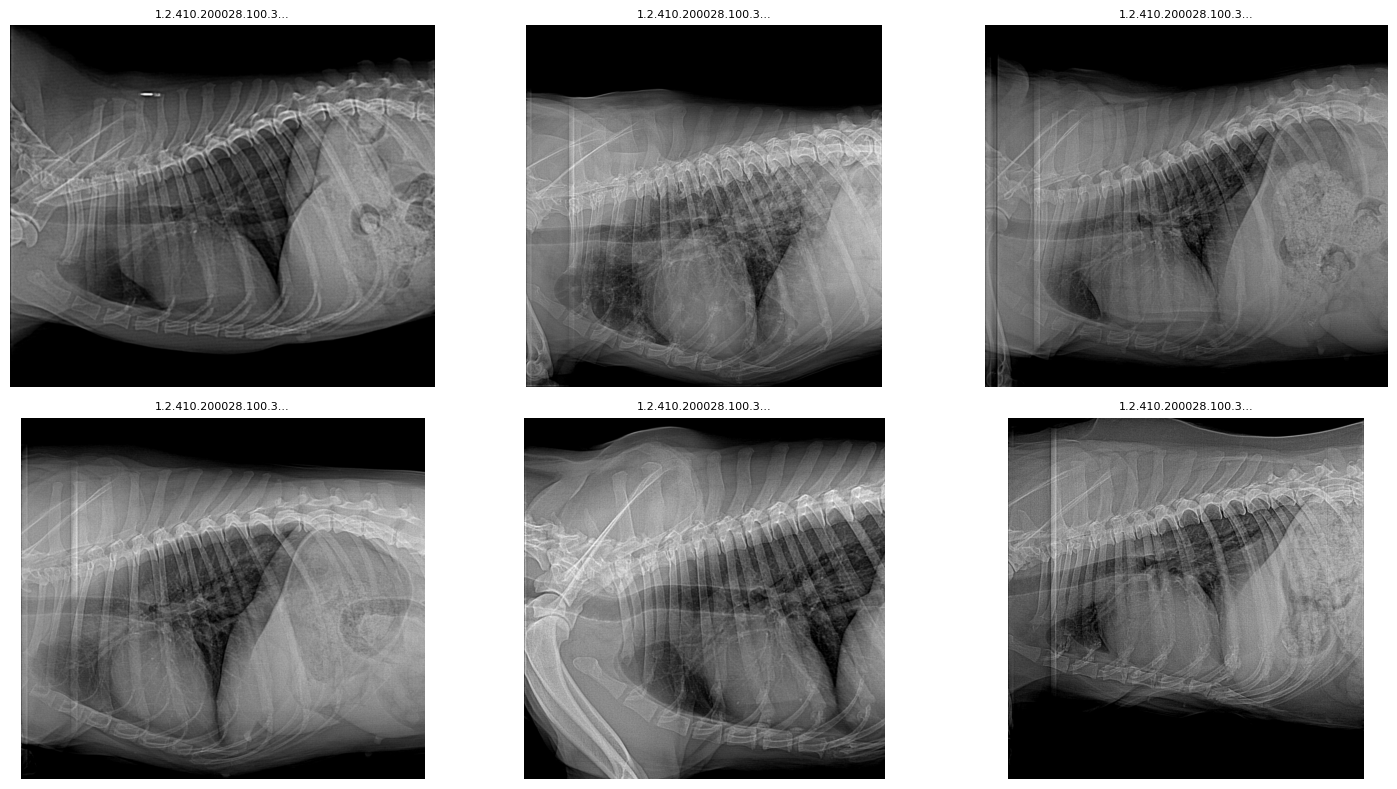


🧠 Cluster 1


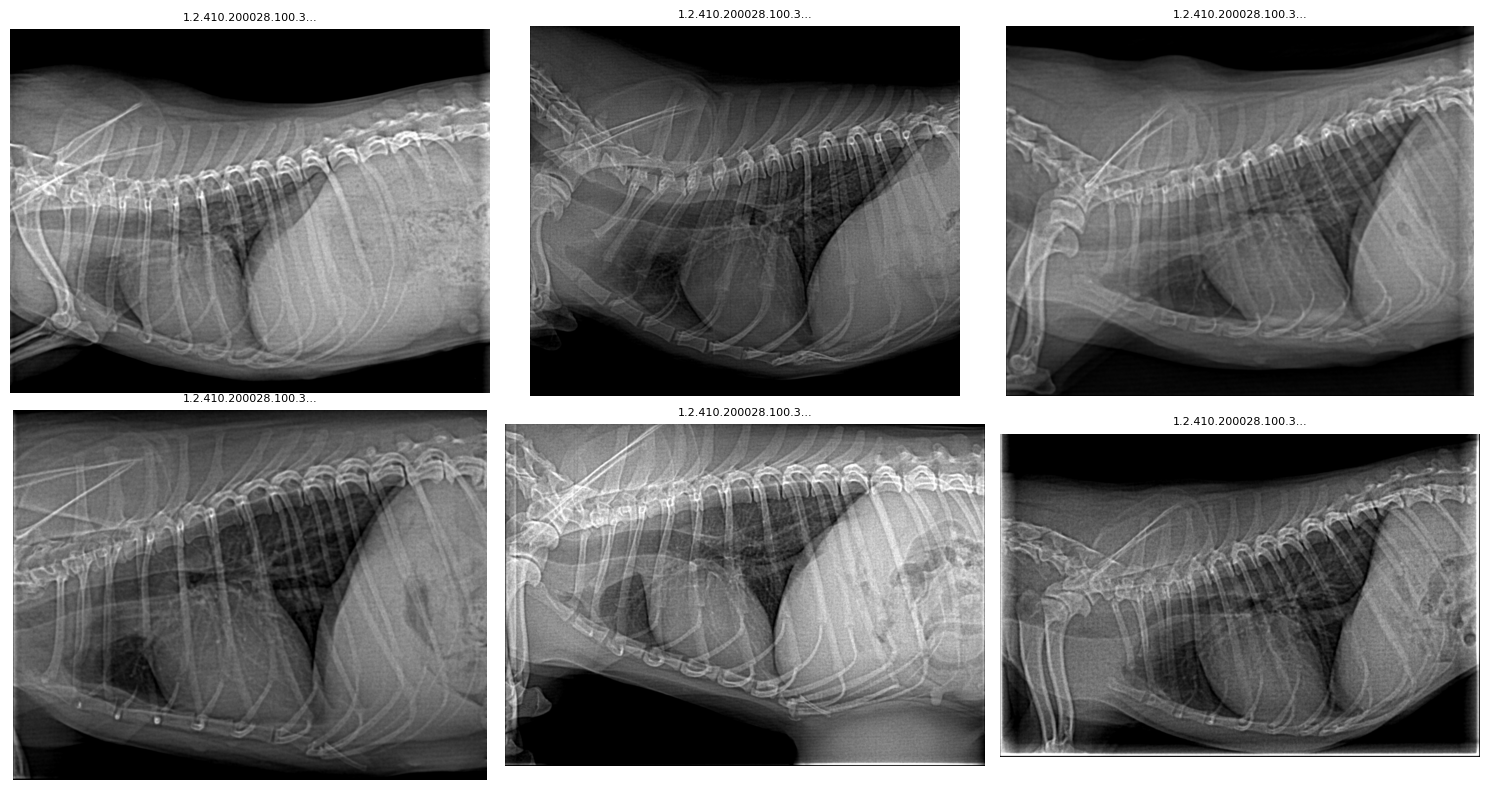


🧠 Cluster 2


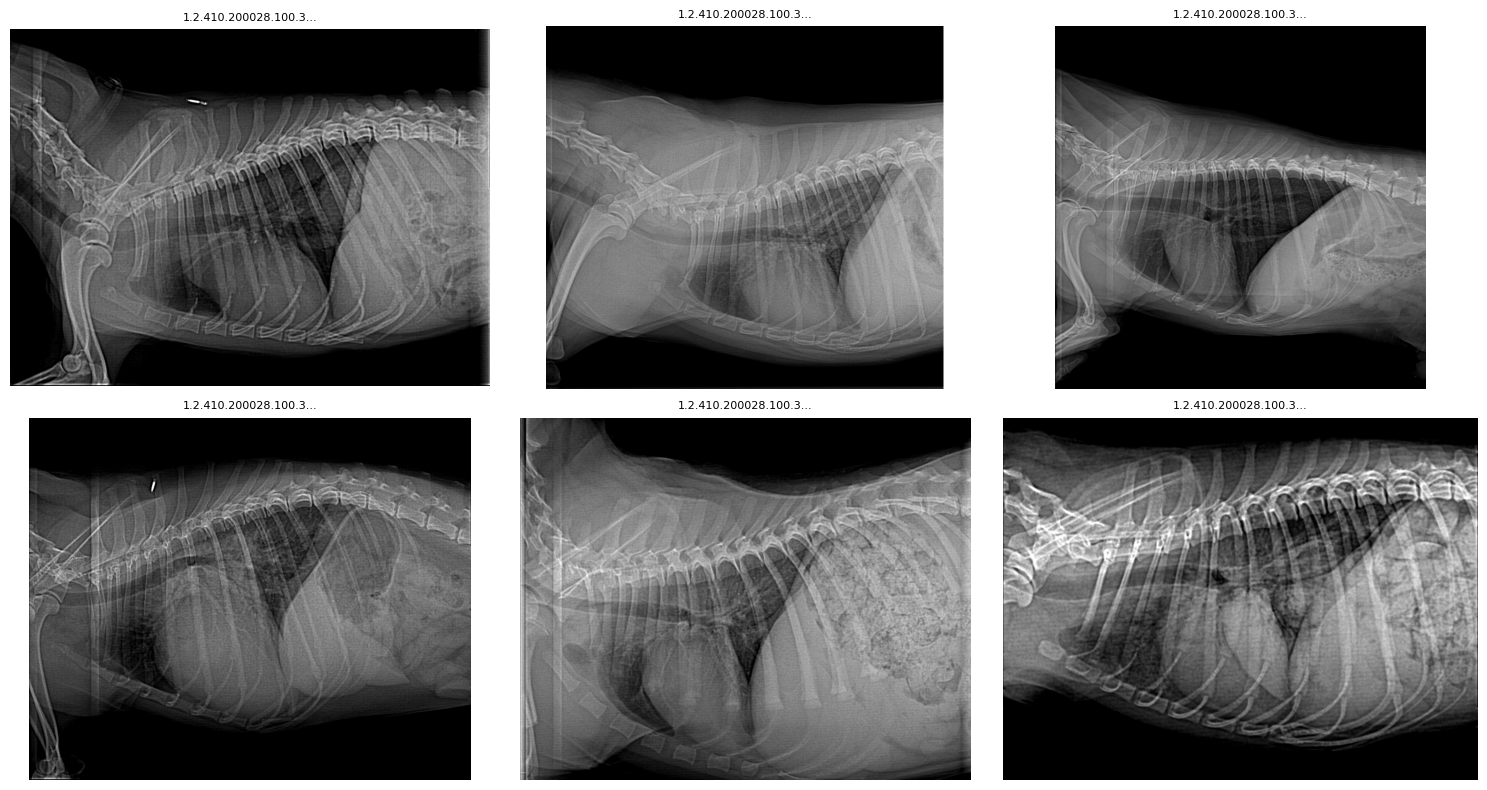

In [82]:
show_images_per_cluster(clusters, filenames, image_folder="./VHS_dataset", n=6)

In [83]:
def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])
    return transform(image).unsqueeze(0), image


In [84]:
def generate_gradcam(model, input_tensor):
    # Nettoyer les anciennes activations/gradients
    activations.clear()
    gradients.clear()

    # Passer l’image dans le modèle
    output = model(input_tensor)

    # Choisir la classe avec la plus grande activation (même si on ne l’interprète pas)
    pred_class = output.argmax().item()
    score = output[0, pred_class]
    
    # Rétropropagation
    model.zero_grad()
    score.backward()

    # Récupération des activations et gradients
    activation = activations[0].squeeze(0)  # [C, H, W]
    gradient = gradients[0].squeeze(0)      # [C, H, W]

    # Grad-CAM : moyenne pondérée des activations par les gradients
    weights = gradient.mean(dim=(1, 2))     # Moyenne par canal
    cam = torch.zeros(activation.shape[1:], dtype=torch.float32)

    for i, w in enumerate(weights):
        cam += w * activation[i]

    cam = F.relu(cam)
    cam -= cam.min()
    cam /= cam.max()

    return cam.detach().numpy()


In [85]:
import cv2

def overlay_gradcam(original_img, cam, alpha=0.5):
    cam = cv2.resize(cam, original_img.size)
    cam_color = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    cam_color = cv2.cvtColor(cam_color, cv2.COLOR_BGR2RGB)
    
    original_np = np.array(original_img)
    overlayed = np.uint8(alpha * cam_color + (1 - alpha) * original_np)
    
    plt.figure(figsize=(6, 6))
    plt.imshow(overlayed)
    plt.axis('off')
    plt.title("Grad-CAM superposé")
    plt.show()


In [86]:
# Recharger un ResNet18 complet avec FC layer
model = models.resnet18(pretrained=True)
model.eval()

# Et garde target_layer :
target_layer = model.layer4[1].conv2


c:\Users\Dorra Sioud\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Dorra Sioud\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [87]:
import torch.nn.functional as F

# Pour stocker les activations et les gradients
activations = []
gradients = []

# Fonction de hook pour stocker l'activation
def forward_hook(module, input, output):
    activations.clear()
    gradients.clear()
    activations.append(output)
    output.register_hook(lambda grad: gradients.append(grad))

# Ajouter le hook sur la dernière couche convolutionnelle
target_layer = model.layer4[1].conv2
hook_handle = target_layer.register_forward_hook(forward_hook)


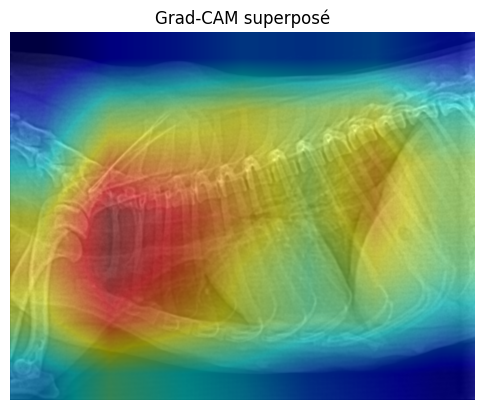

In [88]:
# Choisis une image à tester (ex: image de cluster 2)
test_image_path = os.path.join(image_folder, filenames[12])  # Remplace selon besoin

input_tensor, original_img = preprocess_image(test_image_path)
cam = generate_gradcam(model, input_tensor)
overlay_gradcam(original_img, cam)


In [89]:
def gradcam_grid_per_cluster(clusters, filenames, image_folder, model, n=3, output_dir="./gradcam_output"):
    import os
    import cv2
    import numpy as np
    from PIL import Image

    os.makedirs(output_dir, exist_ok=True)
    unique_clusters = sorted(set(clusters))

    for cluster_id in unique_clusters:
        print(f"\n📊 Cluster {cluster_id} - Grad-CAM")

        cluster_dir = os.path.join(output_dir, f"cluster_{cluster_id}")
        os.makedirs(cluster_dir, exist_ok=True)

        idxs = [i for i, c in enumerate(clusters) if c == cluster_id][:n]
        cols = len(idxs)
        fig, axes = plt.subplots(1, cols, figsize=(5*cols, 5))

        if cols == 1:
            axes = [axes]  # pour éviter erreur si 1 seule image

        for ax, idx in zip(axes, idxs):
            try:
                image_path = os.path.join(image_folder, filenames[idx])
                input_tensor, original_img = preprocess_image(image_path)
                cam = generate_gradcam(model, input_tensor)

                cam_resized = cv2.resize(cam, original_img.size)
                cam_color = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
                cam_color = cv2.cvtColor(cam_color, cv2.COLOR_BGR2RGB)
                original_np = np.array(original_img)
                overlayed = np.uint8(0.5 * cam_color + 0.5 * original_np)

                # Affichage dans la grille
                ax.imshow(overlayed)
                ax.axis('off')
                ax.set_title(f"{filenames[idx][:20]}...", fontsize=8)

                # Sauvegarde
                save_path = os.path.join(cluster_dir, f"gradcam_{filenames[idx]}")
                Image.fromarray(overlayed).save(save_path)

            except Exception as e:
                print(f"❌ Erreur avec {filenames[idx]} : {e}")

        plt.suptitle(f"Grad-CAM - {cluster_names[cluster_id]}", fontsize=14)
        plt.tight_layout()
        plt.show()



📊 Cluster 0 - Grad-CAM


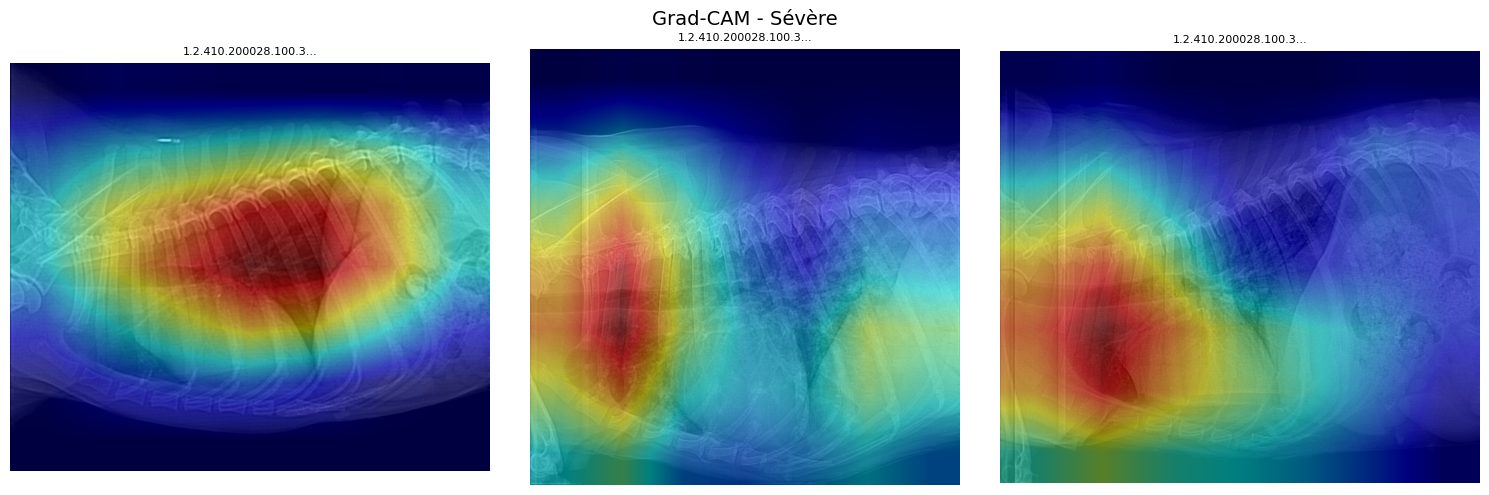


📊 Cluster 1 - Grad-CAM


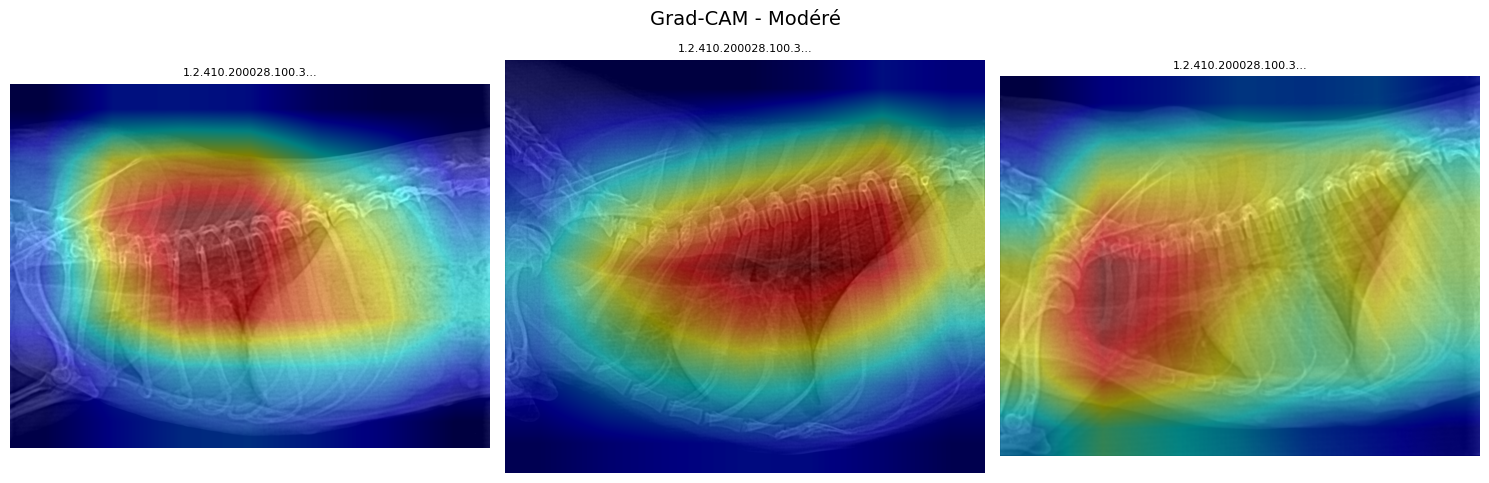


📊 Cluster 2 - Grad-CAM


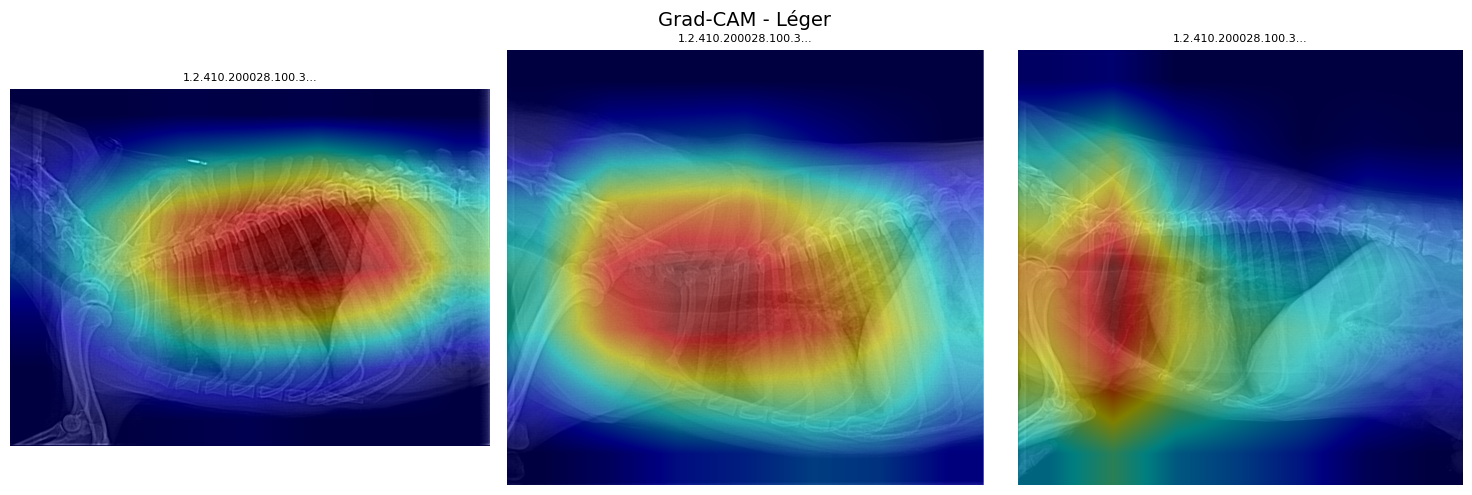

In [90]:
gradcam_grid_per_cluster(clusters, filenames, image_folder, model, n=3)
